# Social media analytics

 #CONTEXT:
  Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.
• DATA DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

#PROJECT OBJECTIVE: 
Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.
Steps and tasks: 
1. Read and explore the data 
2. Retain relevant columns
3. Get length of each sentence 
4. Define parameters
5. Get indices for words
6. Create features and labels
7. Get vocabulary size
8. Create a weight matrix using GloVe embeddings 
9. Define and compile a Bidirectional LSTM model.
Hint: Be analytical and experimental here in trying new approaches to design the best model. 
10. Fit the model and check the validation accuracy

### 1. Read and explore the data

In [1]:
import pandas as pd, numpy as np, re, time
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping
#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
import seaborn as sns


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_json("https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json", lines = True)

In [3]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
print(data.isnull().any(axis = 0))

is_sarcastic    False
headline        False
article_link    False
dtype: bool


Since our dataset doesn’t have any null value. So, we can proceed to clean the data.

In [5]:
# Replacing special symbols and digits in headline column
data['headline'] = data['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

In [6]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word strea...,https://www.theonion.com/mother-comes-pretty-c...


### 2. Retain relevant columns

In [7]:
# dropping article link for further analysis
data = data.drop(['article_link'],axis=1)

In [8]:
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling...
2,0,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word strea...


## 3. Get length of each sentence

In [9]:
#Adding a new feature which will have length of each headline
data['headline_Length'] = data['headline'].apply(len)

In [10]:
data.head()

,is_sarcastic,headline,headline_Length
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep totally nails why congress is falling...,79
2,0,eat your veggies deliciously different recipes,49
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word strea...,61


In [11]:
max_value = data['headline_Length'].max()
print(max_value)

926


#### The longest headline we have in our dataset is 926 words long

## 4. Define parameters

In [13]:
max_features = 2000
maxlen = 200
embedding_size = 50

## 5. Get indices for words

In [19]:
import tensorflow as tf
t = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)

## 6. Create features and labels

In [20]:
#Fit tokenizer with actual training data
t.fit_on_texts(data["headline"].to_list())
features = t.texts_to_sequences(data["headline"].to_list())

features[0]


[352, 2, 641, 1123]

In [23]:
data["headline"][10]

'this lesbian is considered a father in indiana  and an amazing one at that '

In [24]:
len(features)

28619

In [25]:
len(data['is_sarcastic'])

28619

Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

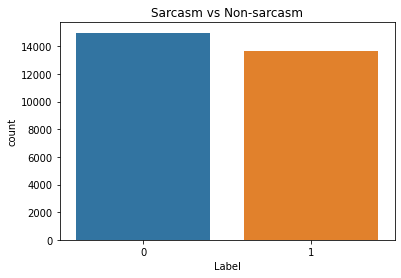

In [26]:
sns.countplot(data.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [51]:
data['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

- We have 28619 labels / total data rows with features extracted for each row.
- In our dataset, label distribution is quite good as it is approx to 50:50 ratio.
- We have 14985 headlines with non-sarcastic as label, defined as 0 in our target column.
- We have 13634 headline with sarcasti as label, defined as 1 in our target column.

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
X = pad_sequences(features , maxlen = maxlen , truncating = 'post')

In [30]:
y = np.asarray(data['is_sarcastic'])

## 7. Get vocabulary size

In [54]:
print('We have',len(t.word_index)+1, 'unique vocabulary in our treated headlines.')

We have 25916 unique vocabulary in our treated headlines.


## 8. Create a weight matrix using GloVe embeddings

In [33]:
embeddings = {}
for emb in open('/Users/sanidhyavishnoi/Downloads/glove.6B.50d.txt',encoding='utf-8'):
    word = emb.split(" ")[0]
#    print(emb)
    embd = emb.split(" ")[1:]
    embd = np.asarray(embd,dtype='float32')
    
    embeddings[word] = embd

In [34]:
num_words = len(t.word_index)+ 1
embedding_matrix =  np.zeros( (num_words , 50) )
for word, i in t.word_index.items():
    emb_vector = embeddings.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector



In [35]:
embedding_matrix.shape

(25916, 50)

In [36]:
y

array([1, 0, 0, ..., 0, 1, 1])

#### Converting array of our target variable to matrix by using get_dummies, as our model accepts matrix as input.

In [55]:
Y = pd.get_dummies(data['is_sarcastic']).values
Y

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

## Splitting data to train & test

In [57]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(X, Y , random_state = 29 , test_size = 0.25)

In [58]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(21464, 200)
(7155, 200)
(21464, 2)
(7155, 2)


In [59]:
import tensorflow as tf
from keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten
from functools import partial

In [60]:
tf.keras.backend.clear_session()

#Building the LSTM Model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(t.word_index) + 1, #Vocablury size
                                    embedding_size, #Embedding size
                                    weights=[embedding_matrix],
                                    input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True),merge_mode='sum'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [61]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_lstm.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [63]:
model_lstm_history = model_lstm.fit(x_train,y_train,batch_size=100,epochs=5,validation_data=(x_test,y_test),callbacks=[es])


Epoch 1/5
215/215 [==============================] - 23s 97ms/step - loss: 0.6413 - accuracy: 0.6648 - val_loss: 0.4044 - val_accuracy: 0.8133
Epoch 2/5
215/215 [==============================] - 20s 94ms/step - loss: 0.3073 - accuracy: 0.8632 - val_loss: 0.3504 - val_accuracy: 0.8412
Epoch 3/5
215/215 [==============================] - 21s 99ms/step - loss: 0.2399 - accuracy: 0.8990 - val_loss: 0.4242 - val_accuracy: 0.8377
Epoch 4/5
215/215 [==============================] - 24s 110ms/step - loss: 0.1941 - accuracy: 0.9235 - val_loss: 0.3967 - val_accuracy: 0.8428
Epoch 5/5
215/215 [==============================] - 35s 161ms/step - loss: 0.1503 - accuracy: 0.9384 - val_loss: 0.4892 - val_accuracy: 0.8281


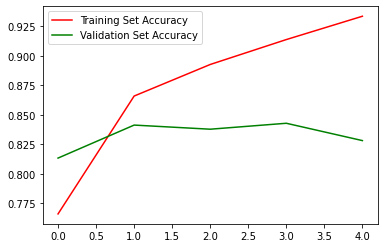

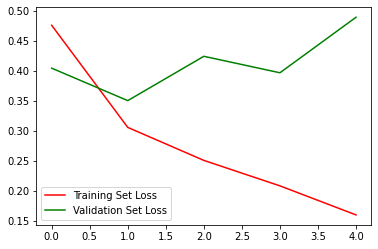

In [75]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=model_lstm_history.history['accuracy']
val_acc=model_lstm_history.history['val_accuracy']
loss=model_lstm_history.history['loss']
val_loss=model_lstm_history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

plt.plot(epochs,acc,'r',label='Training Set Accuracy')
plt.plot(epochs,val_acc,'g',label='Validation Set Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Set Loss')
plt.plot(epochs,val_loss,'g',label='Validation Set Loss')
plt.legend()
plt.show()

In [65]:
# evaluate the model
loss, accuracy = model_lstm.evaluate(x_test,y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

224/224 - 3s - loss: 0.4892 - accuracy: 0.8281
Accuracy: 82.809222


In [74]:
headline = ['Well, what a surprise.']
headline = t.texts_to_sequences(headline)
headline = pad_sequences(headline , maxlen = maxlen , truncating = 'post')
sentiment = model_lstm.predict(headline,batch_size=1,verbose = 1)[0]
if(np.argmax(sentiment) == 0):
    print("Non-sarcastic")
elif (np.argmax(sentiment) == 1):
    print("Sarcastic")

1/1 [==============================] - 0s 27ms/step
Sarcastic


## Conclusions

1. Loss for training set is decreasing in every epoch, but for validation set it is not getting along, we can work on decreasing that.
2. Tried different optimizers, decided to move along with Adam with combination of specific learning rate.
3. Accuracy is increasing, but it is over-fitting a little bit as the increase in training accuracy is way much more if compared with validation accuracy.
4. Used different combination of dense layer with LSTM layer having 20 size.
5. We can use different set of features to overcome over-fitting of our model.
6. We can further optimize our model by using distinct maxlen, embedding_size.